In [35]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

## (6/8) Логистическая регрессия Реализация

Реализуем логистическую регрессию

- В случае логистической регрессией, мы можем использовать только градиентный спуск
- Потому что нет явного матричного способа найти оптимальные коэффициенты

#### Функция Потерь

Функция ошибки для логистической регрессии в случае бинарной классификации называется `бинарной кросс-энтропией` (log loss) и записывается следующим образом:


$$L=-\frac{1}{n}(y_i \log h_{\theta}(x_i) + (1-y_i) \log(1-h_{\theta}(x_i))),$$


где $x_i$ — вектор признаков $i$-го примера из обучающей выборки, $y_i$ — истинный класс для соответствующего примера (0 или 1), $n$ — число примеров в обучающей выборке, $h_{\theta}(x)$ — sigmoid функция, равная:


$$h_{\theta}(x)=\frac{1}{1+\exp^{-\theta x}},$$


где $\theta$ — вектор параметров логистической регрессии, $x$ - вектор признаков объекта из выборки.

Соответствующий градиент функции ошибки равен:

$$\nabla L=\frac{1}{n}\sum_{i=1}^{n}{(h_{\theta}(x_i)-y_i)x_i}$$

Реализация логистической регрессии будет основана на **оптимизации функции ошибки** градиентным спуском.

#### Новый Датасет

В качестве экспериментальных данных возьмем датасет о доходах граждан в различных странах [Adult Income](https://archive.ics.uci.edu/ml/datasets/Adult) и сделаем необходимую предобработку


### Импортируем модули

In [36]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

 ### Импортируем данные
 
 Импортируем данные и добавим названия фичеров

In [37]:
adult = pd.read_csv('adult.data',
                    names=['age', 'workclass', 
                           'fnlwgt', 'education',
                           'education-num', 
                           'marital-status', 
                           'occupation',
                           'relationship', 
                           'race', 'sex', 
                           'capital-gain',
                           'capital-loss',
                           'hours-per-week',
                           'native-country', 
                           'salary'])

adult.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


### Продобработка данных
- Убираем лишние признаки
- Превратим целевоую переменную в бинарную 
- Превратим категориальные признаки в цифровые используя OHE

In [38]:
# Избавиться от лишних признаков
adult.drop(['native-country'], axis=1, inplace=True)

# Сконвертировать целевой столбец в бинарные значения
adult['salary'] = (adult['salary'] != ' <=50K').astype('int32')

# Сделать one-hot encoding для некоторых признаков
adult = pd.get_dummies(adult, columns=['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex'])
adult.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,salary,workclass_ ?,workclass_ Federal-gov,workclass_ Local-gov,...,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,race_ Amer-Indian-Eskimo,race_ Asian-Pac-Islander,race_ Black,race_ Other,race_ White,sex_ Female,sex_ Male
0,39,77516,13,2174,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
1,50,83311,13,0,0,13,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
2,38,215646,9,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
3,53,234721,7,0,0,40,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
4,28,338409,13,0,0,40,0,0,0,0,...,0,0,1,0,0,1,0,0,1,0


- Нормализуем данные 

In [39]:
# Нормализовать нуждающиеся в этом признаки
a_features = adult[['age', 'education-num', 'hours-per-week', 'fnlwgt', 'capital-gain', 'capital-loss']].values
norm_features = (a_features - a_features.mean(axis=0)) / a_features.std(axis=0)
adult.loc[:, ['age', 'education-num', 'hours-per-week', 'fnlwgt', 'capital-gain', 'capital-loss']] = norm_features
adult.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,salary,workclass_ ?,workclass_ Federal-gov,workclass_ Local-gov,...,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,race_ Amer-Indian-Eskimo,race_ Asian-Pac-Islander,race_ Black,race_ Other,race_ White,sex_ Female,sex_ Male
0,0.030671,-1.063611,1.134739,0.148453,-0.21666,-0.035429,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
1,0.837109,-1.008707,1.134739,-0.145920,-0.21666,-2.222153,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
2,-0.042642,0.245079,-0.420060,-0.145920,-0.21666,-0.035429,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
3,1.057047,0.425801,-1.197459,-0.145920,-0.21666,-0.035429,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
4,-0.775768,1.408176,1.134739,-0.145920,-0.21666,-0.035429,0,0,0,0,...,0,0,1,0,0,1,0,0,1,0


In [40]:
# Разбить таблицу данных на матрицы X и y
X = adult[list(set(adult.columns) - set(['salary']))].values
y = adult['salary'].values

# Добавить фиктивный столбец единиц (bias линейной модели)
X = np.hstack([np.ones(X.shape[0])[:,None], X])
m = X.shape[1]
print(m,'features')
print(X.shape[0],'instances')

67 features
32561 instances


### Функции для градиентного спуска

- Риализуем функцию `sigmoid`
- Функцию вычисляющую градиент `бинарной кросс-энтропии` (функция потерь)

In [41]:
from tqdm.notebook import tqdm

# Функция Сигмойда

def sigmoid(X, theta):
    return 1. / (1. + np.exp(-X.dot(theta)))

# Градиент бинарной кросс энтропии
# sigmoid(X,theta) - классификации
# X.theta - регресии

def bin_crossentropy_grad(X, y, theta):
    n = X.shape[0]
    grad = 1. / n * X.T.dot(sigmoid(X, theta) - y  )
    return grad

# Шаг градиентного спука

def gradient_step(theta, theta_grad, alpha):
    return theta - alpha * theta_grad

# Главная функция 

def optimize(X, y, grad_func, start_theta, alpha, n_iters):
    
    theta = start_theta.copy()
    
    for i in tqdm(range(n_iters)):
        theta_grad = grad_func(X, y, theta)
        theta = gradient_step(theta, theta_grad, alpha)
    
    return theta

#### Инициализируем theta
- Для всех рядов инициализируем theta0

In [42]:
theta_0 = np.ones(m)
theta_0[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

#### Оптимизируем theta

In [43]:
# Оптимизировать параметр линейной регрессии theta на всех данных
theta = optimize(X=X, y=y,
                 grad_func=bin_crossentropy_grad, # gradient evaluation function
                 start_theta=theta_0,  # staring theta
                 alpha=1.0,   # learning rate
                 n_iters=300)  # number of iterations

theta[:10]   

  0%|          | 0/300 [00:00<?, ?it/s]

array([-3.18220152, -0.42823004,  0.97474756,  0.15989786, -0.01292206,
        0.36229989,  0.93396207,  0.07795   ,  2.2171966 ,  0.23652037])

In [44]:
def print_logisitc_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f'acc = {acc:.2f} F1-score = {f1:.2f}')

# Сделать предсказания на тренировочной выборке и
# посчитать значение метрики accuracy и F1-score
y_pred = sigmoid(X, theta) > 0.5
print(y_pred[:10])
print_logisitc_metrics(y, y_pred)


[False False False False  True  True False False  True  True]
acc = 0.85 F1-score = 0.65


### train/test разбиение 

- Мы уже знаем, что этой выборке нельзя доверять, поэтому разбиваем данные и оптимизируем
- Результат практически тот же. Отрисуем ROC-кривую, посчитаем её значения и значение площади под кривой AUC

In [45]:
# Разбить выборку на train/valid, оптимизировать theta,
# сделать предсказания и посчитать ошибку F1-score

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

theta = optimize(X_train, y_train, bin_crossentropy_grad, np.ones(m), 1., 300)
y_pred = sigmoid(X_valid, theta) > 0.5

print_logisitc_metrics(y_valid, y_pred)

  0%|          | 0/300 [00:00<?, ?it/s]

acc = 0.86 F1-score = 0.67


In [46]:
from sklearn.metrics import roc_curve, roc_auc_score

# Отрисовать ROC кривую
def calc_and_plot_roc(y_true, y_pred_proba):
    # Посчитать значения ROC кривой и значение площади под кривой AUC
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    
    plt.figure(figsize=(4, 4))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.title('Receiver Operating Characteristic', fontsize=10)
    plt.xlabel('False positive rate (FPR)', fontsize=10)
    plt.ylabel('True positive rate (TPR)', fontsize=10)
    plt.legend(fontsize=10)

[0.32667647 0.30271794 0.11623811 ... 0.19231875 0.4571544  0.34117849]


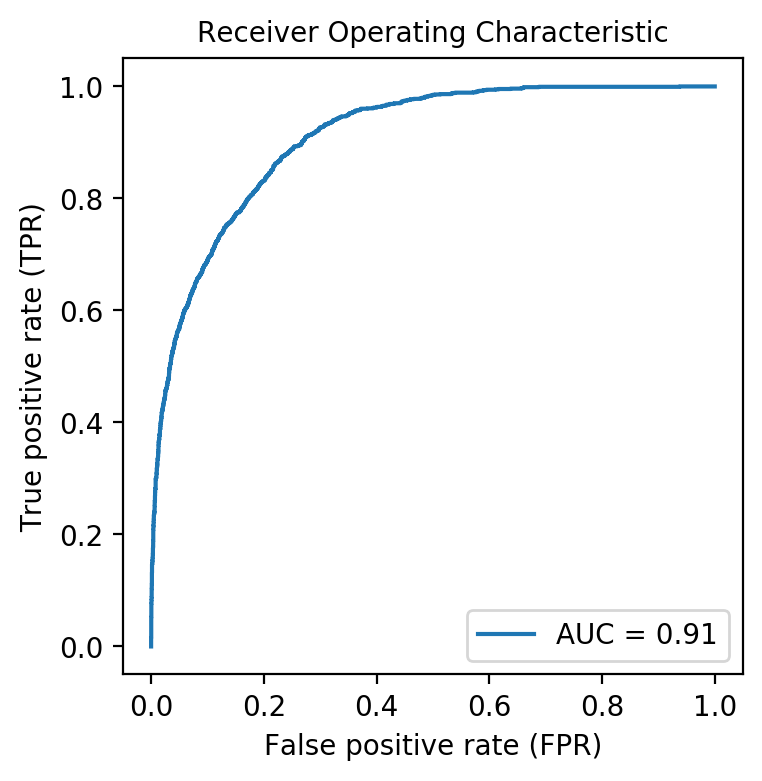

In [47]:
# Вычислить вероятности принадлежности классу 1 для каждого объекта из валидационной выборки
y_pred_proba = sigmoid(X_valid, theta)
print(y_pred_proba)
calc_and_plot_roc(y_valid, y_pred_proba)

## Добавление регуляризации

- Для борьбы с переобучением добавим регуляризацию 
- Обернём линейную регрессию в класс
- Потом добавим вариант с регуляризации 

### Оборачивание линейной регрессии

- Добавим то что мы добавили ранее в классовую форму
- `regOptimiser` добавляем общие функции которые используются как и в регрессии так и в классификации ГС

In [50]:
class regOpt():
    
    # initialisation
    
    def __init__(self, alpha, n_iters):
        self.theta = None
        self._alpha = alpha
        self._n_iters = n_iters
    
    # gradient step
    
    def gradient_step(self, theta, theta_grad):
        return theta - self._alpha * theta_grad
    
    # gradient function
    
    def grad_func(self, X, y, theta):
        raise NotImplementedError()

    # optimisation process of theta
        
    def optimize(self, X, y, start_theta, n_iters):
        
        # theta_0
        theta = start_theta.copy()

        for _ in range(n_iters):
            theta_grad = self.grad_func(X, y, theta)
            theta = self.gradient_step(theta, theta_grad)

        return theta
    
    def fit(self, X, y):
        m = X.shape[1]
        start_theta = np.ones(m)
        self.theta = self.optimize(X, y, start_theta, self._n_iters)
        
    def predict(self, X):
        raise NotImplementedError()

Для реализации ГС нам нужно две функии для того чтобы использовать `regOptimiser`
- Вычисления градиента `grad_func`
- Предсказание `predict`

In [51]:
# linReg будет иметь доступ к функции из regOptimiser

class LinReg(regOpt):
    
    # для линейной регресии у нас функция потерь
    
    def grad_func(self, X, y, theta):
        n = X.shape[0]
        grad = 1.0 / n * X.T.dot(X.dot(theta) - y)
        return grad

    def predict(self, X):
        if(self.theta is None):
            raise Exception('You should train the model first')
        
        y_pred = X.dot(self.theta)
        
        return y_pred

#### Подтвердим на практике для ЛР
- Проверим, работает ли класс градиентного спуска как нужно для линейной регрессии

In [52]:
def print_regression_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    print(f'MSE = {mse:.2f}, RMSE = {rmse:.2f}')
    
def prepare_boston_data():
    data = load_boston()
    X, y = data['data'], data['target']
    # Нормализовать даннные с помощью стандартной нормализации
    X = (X - X.mean(axis=0)) / X.std(axis=0)
    # Добавить фиктивный столбец единиц (bias линейной модели)
    X = np.hstack([np.ones(X.shape[0])[:, np.newaxis], X])
    
    return X, y

linreg = LinReg(0.01, 500)
X, y = prepare_boston_data()
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_valid)
print_regression_metrics(y_valid, y_pred)

MSE = 18.50, RMSE = 4.30


### Оборачивание логистической регрессии

- Теперь так же и для классификации, нужен `grad_func` и `predict`

In [53]:
class LogReg(regOpt):
    
    def sigmoid(self, X, theta):
        return 1. / (1. + np.exp(-X.dot(theta)))
    
    def grad_func(self, X, y, theta):
        n = X.shape[0]
        grad = 1. / n * X.T.dot(self.sigmoid(X, theta) - y)

        return grad
    
    def predict_proba(self, X):
        return self.sigmoid(X, self.theta)
    
    def predict(self, X):
        if self.theta is None:
            raise Exception('You should train the model first')
        
        y_pred = self.predict_proba(X) > 0.5
        
        return y_pred

In [54]:
def prepare_adult_data():
    
    adult = pd.read_csv('adult.data',
                        names=['age', 'workclass', 'fnlwgt', 'education',
                               'education-num', 'marital-status', 'occupation',
                               'relationship', 'race', 'sex', 'capital-gain',
                               'capital-loss', 'hours-per-week', 'native-country', 'salary'])
    
    # Избавиться от лишних признаков
    adult.drop(['native-country'], axis=1, inplace=True)
    # Сконвертировать целевой столбец в бинарные значения
    adult['salary'] = (adult['salary'] != ' <=50K').astype('int32')
    # Сделать one-hot encoding для некоторых признаков
    adult = pd.get_dummies(adult, columns=['workclass', 'education', 'marital-status', 
                                           'occupation', 'relationship', 'race', 'sex'])
    
    # Нормализовать нуждающиеся в этом признаки
    a_features = adult[['age', 'education-num', 'hours-per-week', 'fnlwgt', 'capital-gain', 'capital-loss']].values
    norm_features = (a_features - a_features.mean(axis=0)) / a_features.std(axis=0)
    adult.loc[:, ['age', 'education-num', 'hours-per-week', 'fnlwgt', 'capital-gain', 'capital-loss']] = norm_features
    
    # Разбить таблицу данных на матрицы X и y
    X = adult[list(set(adult.columns) - set(['salary']))].values
    y = adult['salary'].values

    # Добавить фиктивный столбец единиц (bias линейной модели)
    X = np.hstack([np.ones(X.shape[0])[:,None], X])
    
    return X, y

#### Проверим на практике для ЛР

- Проверим, работает ли класс градиентного спуска как нужно для логистической регресии

In [55]:
logreg = LogReg(1., 300)
X, y = prepare_adult_data()
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

# Разбить выборку на train/valid, оптимизировать theta,
# сделать предсказания и посчитать ошибку F1-score

logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_valid)
print_logisitc_metrics(y_valid, y_pred)

acc = 0.84 F1-score = 0.63


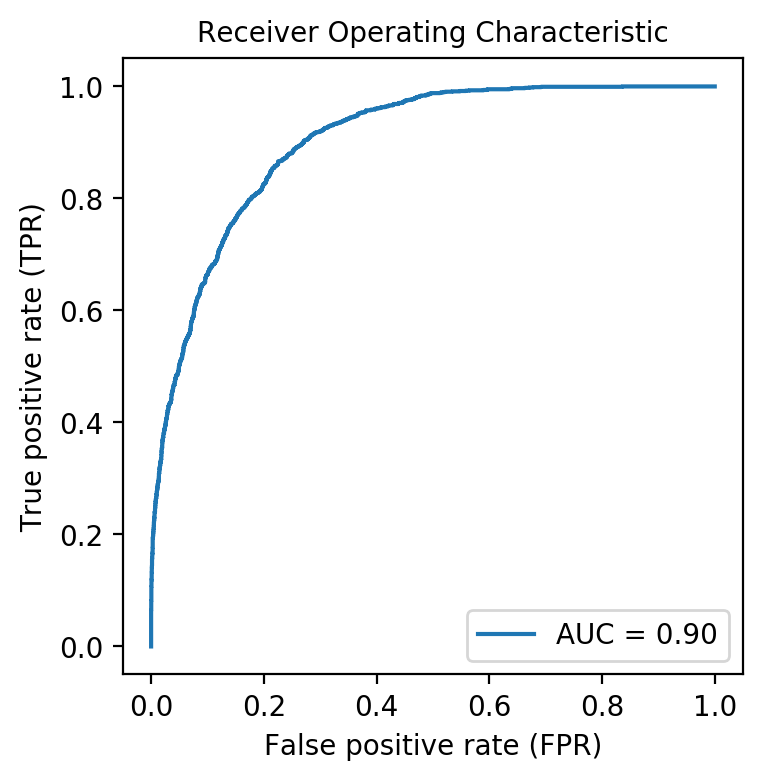

In [56]:
y_pred_proba = logreg.predict_proba(X_valid)
calc_and_plot_roc(y_valid, y_pred_proba)

### Обобщающая способность

В случаях линейной и логистической регрессии будем добавлять к <code>функции ошибки</code> регуляризующую часть как:
$$\frac{\lambda}{2m}\sum_{j}^{m}{\theta_j^2},$$
где $\theta$ — вектор параметров линейной модели без фиктивного признака (intercept/bias term), $m$ — количество нефиктивных признаков, $\lambda$ — параметр регуляризации.

### Добавление регуляризатора в линейную регрессию

После добавления регуляризации `функция ошибки` линейной регрессии будет выглядеть следующим образом:


$$L=\frac{1}{2n} * \sum_{i=1}^{n}{(y_i - \theta^Tx_i)^2} + \frac{\lambda}{2m}\sum_{j}^{m}{\theta_j^2}$$


А ее градиент по параметру $\theta$:


$$\nabla L = \frac{1}{n}\sum_{i=1}^{n}{(\theta^Tx_i - y_i) \cdot x_i} + \frac{\lambda}{m}\sum_{j=1}^{m}{\theta_j} = \frac{1}{n}X^T(X\theta - y) + \frac{\lambda}{m}\sum_{j=1}^{m}{\theta_j}$$

In [60]:
class rLinReg(LinReg):
    
    def __init__(self, alpha, lambd, n_iters):
        super(rLinReg, self).__init__(alpha, n_iters)
        self._lambd = lambd 
    
    def grad_func(self, X, y, theta):
        n = X.shape[0]
        grad = 1. / n * X.T.dot(X.dot(theta) - y) # стандартный градиент функции потерь
        grad_term = self._lambd * np.mean(theta)  # дополнительный термин
        return grad + grad_term

In [61]:
linreg = rLinReg(alpha=0.01, lambd=0.05, n_iters=500)
X, y = prepare_boston_data()
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

In [62]:
linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_valid)
print_regression_metrics(y_valid, y_pred)

MSE = 30.02, RMSE = 5.48


### Добавление регуляризатора в логистическую регрессию

Функция ошибки для логистической регрессии в случае бинарной классификации с регуляризатором записывается следующим образом:
$$L=-\frac{1}{n}(y_i \log h_{\theta}(x_i) + (1-y_i) \log(1-h_{\theta}(x_i)))+\frac{\lambda}{2m}\sum_{j}^{m}{\theta_j^2},$$
где $x_i$ — вектор признаков $i$-го примера из обучающей выборки, $y_i$ — истинный класс для соответствующего примера (0 или 1), $n$ — число примеров в обучающей выборке, $m$ — количество нефиктивных признаков, $\lambda$ — параметр регуляризации, $h_{\theta}(x)$ — sigmoid функция, равная:
$$h_{\theta}(x)=\frac{1}{1+\exp^{-\theta x}},$$
где $\theta$ — вектор параметров логистической регрессии, $x$ - вектор признаков объекта из выборки.

Соответствующий градиент функции ошибки равен:
$$\nabla L=\frac{1}{n}\sum_{i=1}^{n}{(h_{\theta}(x_i)-y_i)x_i}+\frac{\lambda}{m}\sum_{j}^{m}{\theta_j}$$

In [63]:
class rLogReg(LogReg):
    def __init__(self, alpha, lambd, n_iters):
        super(rLogReg, self).__init__(alpha, n_iters)
        self._lambd = lambd
    
    def grad_func(self, X, y, theta):
        n = X.shape[0]
        grad = 1. / n * X.T.dot(self.sigmoid(X, theta) - y) 
        grad_term = self._lambd * np.mean(theta)

        return grad + grad_term

In [64]:
logreg = rLogReg(alpha=1., lambd=1., n_iters=300)
X, y = prepare_adult_data()
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

In [65]:
# Разбить выборку на train/valid, оптимизировать theta,
# сделать предсказания и посчитать ошибку F1-score

logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_valid)

print_logisitc_metrics(y_valid, y_pred)

acc = 0.86 F1-score = 0.67


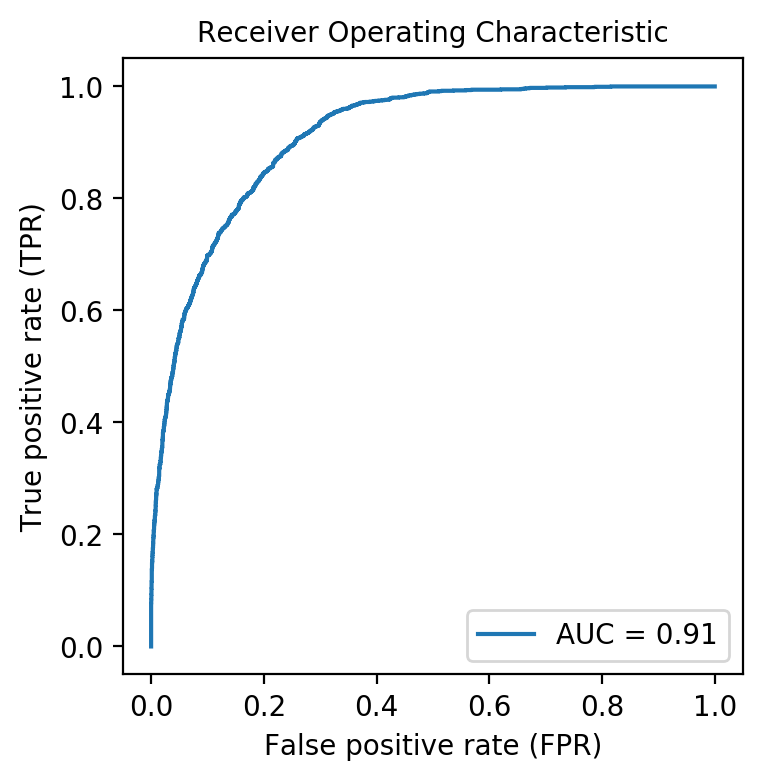

In [66]:
y_pred_proba = logreg.predict_proba(X_valid)
calc_and_plot_roc(y_valid, y_pred_proba)